# Практика застосування лінійної регресії

In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

## EDA датасету California Housing

### Знайомство з даними

In [2]:
california_housing = fetch_california_housing(as_frame=True)

data = california_housing['frame']
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### Визначення цільової змінної

In [3]:
target = data.pop('MedHouseVal')
target.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

### Перевірка типів даних і відсутніх значень

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


### Розподіл ознак

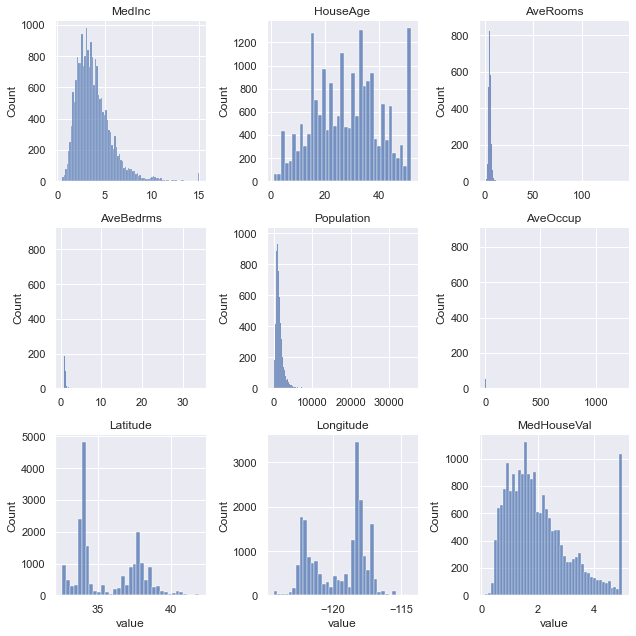

In [5]:
sns.set_theme()

melted = pd.concat([data, target], axis=1).melt()

g = sns.FacetGrid(melted,
                  col='variable',
                  col_wrap=3,
                  sharex=False,
                  sharey=False)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    g.map(sns.histplot, 'value')

g.set_titles(col_template='{col_name}')

g.tight_layout()

In [6]:
features_of_interest = ['AveRooms', 'AveBedrms', 'AveOccup', 'Population']
data[features_of_interest].describe()

,AveRooms,AveBedrms,AveOccup,Population
count,20640.000000,20640.000000,20640.000000,20640.000000
mean,5.429000,1.096675,3.070655,1425.476744
std,2.474173,0.473911,10.386050,1132.462122
min,0.846154,0.333333,0.692308,3.000000
25%,4.440716,1.006079,2.429741,787.000000
50%,5.229129,1.048780,2.818116,1166.000000
75%,6.052381,1.099526,3.282261,1725.000000
max,141.909091,34.066667,1243.333333,35682.000000


### Вибір ознак для моделювання

Text(0.5, 1.0, 'Median house value depending of\n their spatial location')

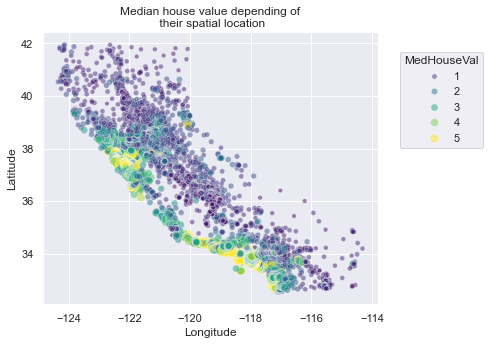

In [7]:
fig, ax = plt.subplots(figsize=(6, 5))

sns.scatterplot(
    data=data,
    x='Longitude',
    y='Latitude',
    size=target,
    hue=target,
    palette='viridis',
    alpha=0.5,
    ax=ax)

plt.legend(
    title='MedHouseVal',
    bbox_to_anchor=(1.05, 0.95),
    loc='upper left')

plt.title('Median house value depending of\n their spatial location')

### Матриця кореляції змінних

<Axes: >

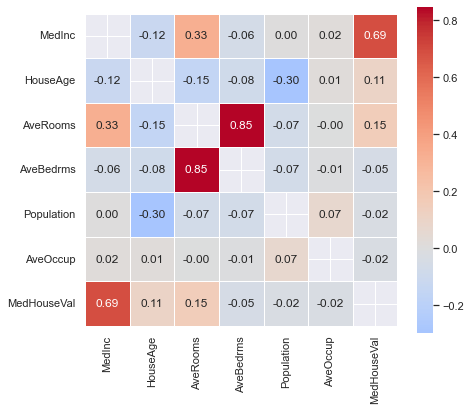

In [8]:
columns_drop = ['Longitude', 'Latitude']
subset = pd.concat([data, target], axis=1).drop(columns=columns_drop)

corr_mtx = subset.corr()

mask_mtx = np.zeros_like(corr_mtx)
np.fill_diagonal(mask_mtx, 1)

fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(subset.corr(),
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt='.2f',
            linewidth=0.5,
            square=True,
            mask=mask_mtx,
            ax=ax)

## Підготовка і обробка даних

### Розбиття на тренувальну і тестову вибірки

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    data,
    target,
    test_size=0.2,
    random_state=42)

### Нормалізація змінних

In [10]:
scaler = StandardScaler().set_output(transform='pandas').fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
X_train_scaled.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04
mean,-6.519333e-17,-9.251859e-18,-1.981081e-16,-1.707291e-16,-2.151595e-19,4.936566e-17,6.400995e-17,1.753335e-15
std,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00
min,-1.775438e+00,-2.190766e+00,-1.904386e+00,-1.762117e+00,-1.251913e+00,-2.076846e-01,-1.447697e+00,-2.377207e+00
25%,-6.900689e-01,-8.417859e-01,-4.118373e-01,-2.081645e-01,-5.606339e-01,-5.770769e-02,-8.018107e-01,-1.110749e+00
50%,-1.758995e-01,3.108328e-02,-8.350905e-02,-1.094160e-01,-2.281865e-01,-2.415892e-02,-6.473597e-01,5.346501e-01
75%,4.686502e-01,6.658972e-01,2.621376e-01,8.455177e-03,2.634487e-01,1.580865e-02,9.720351e-01,7.839530e-01
max,5.839268e+00,1.856173e+00,5.716655e+01,5.664727e+01,3.012743e+01,1.071164e+02,2.951816e+00,2.628794e+00


## Навчання і оцінка моделі

### Побудова моделі

In [12]:
model = LinearRegression().fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

ymin, ymax = y_train.agg(['min', 'max']).values

y_pred = pd.Series(y_pred, index=X_test_scaled.index).clip(ymin, ymax)
y_pred.head()

20046    0.719123
3024     1.764017
15663    2.709659
20484    2.838926
9814     2.604657
dtype: float64

### Оцінювання точності моделі

In [13]:
r_sq = model.score(X_train_scaled, y_train)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'R2: {r_sq:.2f} | MAE: {mae:.2f} | MAPE: {mape:.2f}')

R2: 0.61 | MAE: 0.52 | MAPE: 0.31


In [14]:
pd.Series(model.coef_, index=X_train_scaled.columns)

MedInc        0.854383
HouseAge      0.122546
AveRooms     -0.294410
AveBedrms     0.339259
Population   -0.002308
AveOccup     -0.040829
Latitude     -0.896929
Longitude    -0.869842
dtype: float64

### Поліноміальна регресія

In [15]:
# [a, b] -> [1, a, b, a^2, ab, b^2]
poly = PolynomialFeatures(2).set_output(transform='pandas')

Xtr = poly.fit_transform(X_train_scaled)
Xts = poly.transform(X_test_scaled)

model_upd = LinearRegression().fit(Xtr, y_train)
y_pred_upd = model_upd.predict(Xts)
y_pred_upd = pd.Series(y_pred_upd, index=Xts.index).clip(ymin, ymax)

r_sq_upd = model_upd.score(Xtr, y_train)
mae_upd = mean_absolute_error(y_test, y_pred_upd)
mape_upd = mean_absolute_percentage_error(y_test, y_pred_upd)

print(f'R2: {r_sq_upd:.2f} | MAE: {mae_upd:.2f} | MAPE: {mape_upd:.2f}')

R2: 0.69 | MAE: 0.46 | MAPE: 0.27


<Axes: xlabel='MedHouseVal', ylabel='None'>

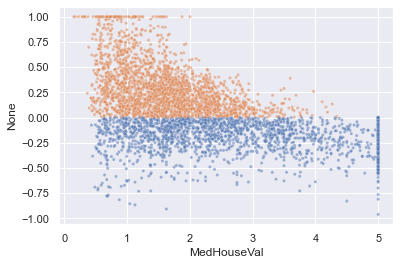

In [16]:
pct_error = (y_pred_upd / y_test - 1).clip(-1, 1)

sns.scatterplot(
    x=y_test,
    y=pct_error,
    hue=pct_error.gt(0),
    alpha=0.5,
    s=10,
    legend=False)